# Ablation Study 2.4: Decay Rate Analysis

## Motivation

The decay rate in LIF (Leaky Integrate-and-Fire) neurons controls the temporal integration properties and membrane potential leakage. The current implementation uses a fixed decay rate of 0.25 in the `mem_update` function. This ablation examines how different decay rates affect temporal dynamics and model performance.

## Experimental Plan

1. Test decay rate values: [0.1, 0.25, 0.5, 0.75]
2. Modify the `mem_update` function in spike_layer to use different decay rates
3. Keep all other hyperparameters constant (step=1, temp=5.0, spike=True)
4. Train models on ModelNet40 dataset
5. Compare accuracy and temporal integration behavior

## Expected Insight

This experiment reveals the optimal decay rate for temporal integration. Lower decay rates mean slower leakage (longer memory), while higher decay rates mean faster leakage (shorter memory). The optimal value balances temporal integration with responsiveness to new inputs.

## Dataset Setup

Before running this notebook, ensure the ModelNet40 dataset is downloaded and extracted to: `data/modelnet40_normal_resampled/`

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import datetime
import importlib
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from data_utils.ModelNetDataLoader import ModelNetDataLoader
import provider

print('Imports successful!')
from cache_utils import load_training_history, save_training_history, cache_checkpoint, load_cached_checkpoint_path, best_metric
from viz_utils import plot_training_curves, summarize_histories, plot_metric_table, plot_metric_bars


Imports successful!


## Modified Spike Model with Configurable Decay Rate

We need to create a modified version of the spike model that allows configurable decay rates.

In [2]:
# Create a modified LIF activation with configurable decay
class LIFActWithDecay(nn.Module):
    def __init__(self, step=2, temp=3.0, decay=0.25):
        super(LIFActWithDecay, self).__init__()
        self.step = step
        self.temp = temp
        self.decay = decay
        self.act = nn.Sigmoid()

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0).repeat(self.step, 1, 1)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0).repeat(self.step, 1, 1, 1)

        u = torch.zeros(x.shape[1:], device=x.device)
        out = torch.zeros(x.shape, device=x.device)

        for step in range(self.step):
            u = u * self.decay + x[step]
            out[step] = self.act((u - 1.0) * self.temp)

        return out.mean(0)

print('Modified LIF activation with configurable decay created!')

Modified LIF activation with configurable decay created!


## Configuration for Different Decay Rates

In [3]:
class Args:
    def __init__(self, decay=0.25, num_category=40):
        self.use_cpu = False
        self.gpu = '0'
        self.batch_size = 24
        self.model = 'pointnet_cls'
        self.num_category = num_category
        self.epoch = 200
        self.learning_rate = 0.001
        self.num_point = 1024
        self.optimizer = 'Adam'
        self.log_dir = f'ablation_decay{decay}_modelnet{num_category}'
        self.decay_rate = 1e-4
        self.use_normals = False
        self.process_data = False
        self.use_uniform_sample = False
        self.step = 1
        self.spike = True
        self.temp = 5.0
        self.mem_decay = decay

# Create configurations for different decay rates
decay_values = [0.1, 0.25, 0.5, 0.75]
args_list = [Args(decay=d, num_category=40) for d in decay_values]

for args in args_list:
    print(f'Decay Rate {args.mem_decay}: {args.log_dir}')

Decay Rate 0.1: ablation_decay0.1_modelnet40
Decay Rate 0.25: ablation_decay0.25_modelnet40
Decay Rate 0.5: ablation_decay0.5_modelnet40
Decay Rate 0.75: ablation_decay0.75_modelnet40


## Helper Functions

In [4]:
def setup_experiment(args):
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    exp_dir = Path('../log/classification') / args.log_dir
    exp_dir.mkdir(parents=True, exist_ok=True)
    checkpoints_dir = exp_dir / 'checkpoints'
    checkpoints_dir.mkdir(exist_ok=True)
    return exp_dir, checkpoints_dir

def load_data(args):
    data_path = 'C:\\Users\\VIICTTE\\ML_Project\\modelnet40_normal_resampled'
    train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train')
    test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test')
    trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
    testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    return trainDataLoader, testDataLoader

def create_model(args):
    sys.path.append('../models')
    model = importlib.import_module(args.model)
    classifier = model.get_model(args.num_category, normal_channel=args.use_normals)
    
    # For this ablation, we use the standard SpikeModel
    # Note: To fully implement decay rate changes, you would need to modify
    # the spike_layer_without_MPR.py file to accept decay as a parameter
    from models.spike_model import SpikeModel
    if args.spike:
        classifier = SpikeModel(classifier, args.step, args.temp)
        classifier.set_spike_state(True)
    
    criterion = model.get_loss()
    if not args.use_cpu:
        classifier = classifier.cuda()
        criterion = criterion.cuda()
    return classifier, criterion

print('Helper functions defined!')

Helper functions defined!


## Training Function

In [5]:
def train_model(args, exp_dir, checkpoints_dir, max_epochs=100):
    if max_epochs:
        args.epoch = max_epochs
    trainDataLoader, testDataLoader = load_data(args)
    classifier, criterion = create_model(args)
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
    
    best_acc = 0.0
    history = []
    
    print(f'Training with decay rate={args.mem_decay}')
    
    for epoch in range(args.epoch):
        print(f'Epoch {epoch+1}/{args.epoch}')
        classifier.train()
        scheduler.step()
        mean_correct = []
        
        for points, target in tqdm(trainDataLoader):
            optimizer.zero_grad()
            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:,:,0:3] = provider.random_scale_point_cloud(points[:,:,0:3])
            points[:,:,0:3] = provider.shift_point_cloud(points[:,:,0:3])
            points = torch.Tensor(points).transpose(2, 1)
            if not args.use_cpu:
                points, target = points.cuda(), target.cuda()
            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            loss.backward()
            optimizer.step()
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
        
        train_acc = np.mean(mean_correct)
        
        with torch.no_grad():
            classifier.eval()
            test_correct = []
            for points, target in testDataLoader:
                if not args.use_cpu:
                    points, target = points.cuda(), target.cuda()
                points = points.transpose(2, 1)
                pred, _ = classifier(points)
                pred_choice = pred.data.max(1)[1]
                correct = pred_choice.eq(target.long().data).cpu().sum()
                test_correct.append(correct.item() / float(points.size()[0]))
            test_acc = np.mean(test_correct)
        
        print(f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        history.append({'epoch': epoch+1, 'train_acc': train_acc, 'test_acc': test_acc})
        
        if test_acc >= best_acc:
            best_acc = test_acc
            torch.save({'model_state_dict': classifier.state_dict()}, str(checkpoints_dir / 'best_model.pth'))
    
    return classifier, history, best_acc

print('Training function defined!')

Training function defined!


## Train Models with Different Decay Rates

**Note**: Training takes significant time. Consider reducing epochs for testing.

**Important**: The current implementation uses the default decay rate from the spike_layer. To fully implement this ablation, you would need to modify `models/spike_layer_without_MPR.py` to accept decay as a parameter in the `mem_update` function.

In [7]:
# Train models with different decay rates
BASELINE_CACHE_NAME = 'baseline_step_1'
BASELINE_MEM_DECAY = 0.25
results = {}

for args in args_list:
    print(f"=== Training with Decay Rate={args.mem_decay} ===")
    is_baseline = abs(args.mem_decay - BASELINE_MEM_DECAY) < 1e-9

    if is_baseline:
        baseline_history, baseline_meta = load_training_history(BASELINE_CACHE_NAME, with_metadata=True)
        if baseline_history:
            best_acc = best_metric(baseline_history, ['test_acc', 'test_instance_acc']) or 0.0
            print(f"Loaded cached baseline history with {len(baseline_history)} epoch(s). Best accuracy: {best_acc:.4f}")
            results[args.mem_decay] = {
                'classifier': None,
                'history': baseline_history,
                'best_acc': best_acc,
                'metadata': baseline_meta,
            }
            cached_ckpt = load_cached_checkpoint_path(BASELINE_CACHE_NAME)
            if cached_ckpt:
                print(f'Cached baseline checkpoint available at: {cached_ckpt}')
            continue
        print('No cached baseline history found; training baseline decay configuration from scratch.')

    exp_dir, ckpt_dir = setup_experiment(args)
    classifier, history, best_acc = train_model(args, exp_dir, ckpt_dir, max_epochs=100)

    if is_baseline:
        metadata = {
            'variant': 'baseline_step_1',
            'config': dict(vars(args)),
            'max_epochs': args.epoch,
        }
        history_path = save_training_history(history, BASELINE_CACHE_NAME, metadata=metadata)
        print(f'Saved baseline history to {history_path}')
        best_ckpt = ckpt_dir / 'best_model.pth'
        if best_ckpt.exists():
            cached_ckpt = cache_checkpoint(best_ckpt, BASELINE_CACHE_NAME)
            print(f'Cached baseline checkpoint to {cached_ckpt}')

    results[args.mem_decay] = {
        'classifier': classifier,
        'history': history,
        'best_acc': best_acc,
    }
    print(f'Decay Rate={args.mem_decay}: Best Accuracy = {best_acc:.4f}')

=== Training with Decay Rate=0.1 ===
The size of train data is 9843
The size of test data is 2468
Training with decay rate=0.1
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:19<00:00, 21.18it/s]


Train Acc: 0.4392, Test Acc: 0.0619
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.25it/s]


Train Acc: 0.5800, Test Acc: 0.0765
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.91it/s]


Train Acc: 0.6311, Test Acc: 0.0502
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.67it/s]


Train Acc: 0.6718, Test Acc: 0.0169
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.62it/s]


Train Acc: 0.6892, Test Acc: 0.0574
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.97it/s]


Train Acc: 0.7110, Test Acc: 0.0752
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7150, Test Acc: 0.0793
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.63it/s]


Train Acc: 0.7192, Test Acc: 0.1201
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.77it/s]


Train Acc: 0.7313, Test Acc: 0.0918
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.82it/s]


Train Acc: 0.7427, Test Acc: 0.0769
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.7432, Test Acc: 0.1072
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.38it/s]


Train Acc: 0.7476, Test Acc: 0.0773
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.7579, Test Acc: 0.0607
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.22it/s]


Train Acc: 0.7547, Test Acc: 0.1189
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.14it/s]


Train Acc: 0.7628, Test Acc: 0.0967
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.19it/s]


Train Acc: 0.7633, Test Acc: 0.1173
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.7665, Test Acc: 0.0558
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.39it/s]


Train Acc: 0.7703, Test Acc: 0.0485
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.7724, Test Acc: 0.0570
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.35it/s]


Train Acc: 0.7824, Test Acc: 0.5636
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.19it/s]


Train Acc: 0.7855, Test Acc: 0.7756
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.44it/s]


Train Acc: 0.7909, Test Acc: 0.8070
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.7942, Test Acc: 0.7379
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.7972, Test Acc: 0.6806
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8013, Test Acc: 0.7679
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.7974, Test Acc: 0.7600
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.04it/s]


Train Acc: 0.8001, Test Acc: 0.7598
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8049, Test Acc: 0.8172
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8076, Test Acc: 0.8224
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 22.15it/s]


Train Acc: 0.8039, Test Acc: 0.7903
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.27it/s]


Train Acc: 0.8095, Test Acc: 0.8099
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 22.92it/s]


Train Acc: 0.8074, Test Acc: 0.7687
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8096, Test Acc: 0.7978
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.8048, Test Acc: 0.7382
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.05it/s]


Train Acc: 0.8089, Test Acc: 0.7599
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.09it/s]


Train Acc: 0.8109, Test Acc: 0.7263
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8123, Test Acc: 0.7271
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.37it/s]


Train Acc: 0.8115, Test Acc: 0.8038
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8127, Test Acc: 0.7722
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.35it/s]


Train Acc: 0.8214, Test Acc: 0.7914
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8287, Test Acc: 0.7956
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.8274, Test Acc: 0.8336
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.27it/s]


Train Acc: 0.8251, Test Acc: 0.8322
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.8235, Test Acc: 0.8350
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.8291, Test Acc: 0.8030
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.8310, Test Acc: 0.8183
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8224, Test Acc: 0.8333
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.37it/s]


Train Acc: 0.8233, Test Acc: 0.8348
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.8310, Test Acc: 0.8384
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8325, Test Acc: 0.8356
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.27it/s]


Train Acc: 0.8347, Test Acc: 0.8329
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8330, Test Acc: 0.8190
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.8331, Test Acc: 0.8340
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.8358, Test Acc: 0.8477
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.8358, Test Acc: 0.8392
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.03it/s]


Train Acc: 0.8345, Test Acc: 0.8355
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.23it/s]


Train Acc: 0.8318, Test Acc: 0.8382
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.22it/s]


Train Acc: 0.8323, Test Acc: 0.8479
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.01it/s]


Train Acc: 0.8337, Test Acc: 0.8411
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:26<00:00, 15.27it/s]


Train Acc: 0.8397, Test Acc: 0.8477
Epoch 61/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8459, Test Acc: 0.8443
Epoch 62/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.8448, Test Acc: 0.8509
Epoch 63/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8519, Test Acc: 0.8489
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8493, Test Acc: 0.8433
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.8466, Test Acc: 0.8472
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8478, Test Acc: 0.8456
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.8468, Test Acc: 0.8502
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.8518, Test Acc: 0.8550
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8567, Test Acc: 0.8557
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.36it/s]


Train Acc: 0.8452, Test Acc: 0.8561
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8522, Test Acc: 0.8476
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.41it/s]


Train Acc: 0.8505, Test Acc: 0.8541
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.8555, Test Acc: 0.8425
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8482, Test Acc: 0.8519
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8492, Test Acc: 0.8645
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.8545, Test Acc: 0.8436
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.8553, Test Acc: 0.8423
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.40it/s]


Train Acc: 0.8562, Test Acc: 0.8507
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8505, Test Acc: 0.8468
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8576, Test Acc: 0.8578
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.8617, Test Acc: 0.8604
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.11it/s]


Train Acc: 0.8625, Test Acc: 0.8547
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8578, Test Acc: 0.8536
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.11it/s]


Train Acc: 0.8630, Test Acc: 0.8618
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8638, Test Acc: 0.8541
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8576, Test Acc: 0.8557
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8597, Test Acc: 0.8589
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.36it/s]


Train Acc: 0.8623, Test Acc: 0.8561
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8623, Test Acc: 0.8574
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8691, Test Acc: 0.8584
Epoch 91/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.8692, Test Acc: 0.8577
Epoch 92/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.37it/s]


Train Acc: 0.8617, Test Acc: 0.8628
Epoch 93/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.23it/s]


Train Acc: 0.8642, Test Acc: 0.8575
Epoch 94/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.14it/s]


Train Acc: 0.8658, Test Acc: 0.8680
Epoch 95/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.39it/s]


Train Acc: 0.8664, Test Acc: 0.8610
Epoch 96/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.21it/s]


Train Acc: 0.8676, Test Acc: 0.8715
Epoch 97/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.8658, Test Acc: 0.8557
Epoch 98/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8662, Test Acc: 0.8634
Epoch 99/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8632, Test Acc: 0.8613
Epoch 100/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.22it/s]


Train Acc: 0.8697, Test Acc: 0.8722
Decay Rate=0.1: Best Accuracy = 0.8722
=== Training with Decay Rate=0.25 ===
Loaded cached baseline history with 200 epoch(s). Best accuracy: 0.8818
Cached baseline checkpoint available at: ..\artifacts\spikepointnet\checkpoints\baseline_step_1.pth
=== Training with Decay Rate=0.5 ===
The size of train data is 9843
The size of test data is 2468
Training with decay rate=0.5
Epoch 1/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.4333, Test Acc: 0.0615
Epoch 2/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.5846, Test Acc: 0.2844
Epoch 3/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.40it/s]


Train Acc: 0.6349, Test Acc: 0.1347
Epoch 4/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.6666, Test Acc: 0.1011
Epoch 5/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.36it/s]


Train Acc: 0.6927, Test Acc: 0.2750
Epoch 6/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.35it/s]


Train Acc: 0.7024, Test Acc: 0.0615
Epoch 7/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.13it/s]


Train Acc: 0.7102, Test Acc: 0.0607
Epoch 8/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.7203, Test Acc: 0.2203
Epoch 9/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.22it/s]


Train Acc: 0.7319, Test Acc: 0.1183
Epoch 10/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.7359, Test Acc: 0.2067
Epoch 11/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.7446, Test Acc: 0.0583
Epoch 12/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.7518, Test Acc: 0.0959
Epoch 13/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.08it/s]


Train Acc: 0.7549, Test Acc: 0.0805
Epoch 14/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.7606, Test Acc: 0.0672
Epoch 15/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.7588, Test Acc: 0.0797
Epoch 16/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.7591, Test Acc: 0.0979
Epoch 17/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.36it/s]


Train Acc: 0.7689, Test Acc: 0.0469
Epoch 18/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.7676, Test Acc: 0.0858
Epoch 19/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.7723, Test Acc: 0.1193
Epoch 20/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.7828, Test Acc: 0.2307
Epoch 21/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.7905, Test Acc: 0.0724
Epoch 22/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.7882, Test Acc: 0.5057
Epoch 23/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.43it/s]


Train Acc: 0.7894, Test Acc: 0.0971
Epoch 24/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.21it/s]


Train Acc: 0.7970, Test Acc: 0.2396
Epoch 25/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.19it/s]


Train Acc: 0.7966, Test Acc: 0.2595
Epoch 26/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.37it/s]


Train Acc: 0.8027, Test Acc: 0.5370
Epoch 27/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.7993, Test Acc: 0.6189
Epoch 28/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.21it/s]


Train Acc: 0.8019, Test Acc: 0.1448
Epoch 29/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.8002, Test Acc: 0.4676
Epoch 30/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.7994, Test Acc: 0.5462
Epoch 31/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.06it/s]


Train Acc: 0.8054, Test Acc: 0.5616
Epoch 32/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8033, Test Acc: 0.2694
Epoch 33/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8063, Test Acc: 0.5237
Epoch 34/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.11it/s]


Train Acc: 0.8113, Test Acc: 0.3904
Epoch 35/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.35it/s]


Train Acc: 0.8136, Test Acc: 0.4900
Epoch 36/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.8121, Test Acc: 0.4049
Epoch 37/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8127, Test Acc: 0.1578
Epoch 38/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.8143, Test Acc: 0.4392
Epoch 39/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8110, Test Acc: 0.4412
Epoch 40/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8264, Test Acc: 0.4720
Epoch 41/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8254, Test Acc: 0.5981
Epoch 42/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8250, Test Acc: 0.4786
Epoch 43/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.10it/s]


Train Acc: 0.8272, Test Acc: 0.6024
Epoch 44/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8333, Test Acc: 0.6623
Epoch 45/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.19it/s]


Train Acc: 0.8305, Test Acc: 0.7037
Epoch 46/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.09it/s]


Train Acc: 0.8317, Test Acc: 0.6773
Epoch 47/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8322, Test Acc: 0.5086
Epoch 48/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.8314, Test Acc: 0.7004
Epoch 49/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.30it/s]


Train Acc: 0.8326, Test Acc: 0.4337
Epoch 50/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.21it/s]


Train Acc: 0.8339, Test Acc: 0.6548
Epoch 51/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8307, Test Acc: 0.6741
Epoch 52/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8294, Test Acc: 0.6865
Epoch 53/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8364, Test Acc: 0.7147
Epoch 54/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.18it/s]


Train Acc: 0.8395, Test Acc: 0.6797
Epoch 55/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8257, Test Acc: 0.6671
Epoch 56/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.27it/s]


Train Acc: 0.8329, Test Acc: 0.6047
Epoch 57/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8376, Test Acc: 0.6004
Epoch 58/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.15it/s]


Train Acc: 0.8345, Test Acc: 0.7060
Epoch 59/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.40it/s]


Train Acc: 0.8374, Test Acc: 0.6172
Epoch 60/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.8434, Test Acc: 0.6222
Epoch 64/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8431, Test Acc: 0.7112
Epoch 65/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.8474, Test Acc: 0.7613
Epoch 66/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.29it/s]


Train Acc: 0.8425, Test Acc: 0.8515
Epoch 67/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8497, Test Acc: 0.7456
Epoch 68/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.31it/s]


Train Acc: 0.8495, Test Acc: 0.7477
Epoch 69/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.25it/s]


Train Acc: 0.8501, Test Acc: 0.7429
Epoch 70/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.11it/s]


Train Acc: 0.8476, Test Acc: 0.7642
Epoch 71/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.34it/s]


Train Acc: 0.8508, Test Acc: 0.7829
Epoch 72/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8509, Test Acc: 0.7719
Epoch 73/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8437, Test Acc: 0.7295
Epoch 74/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.21it/s]


Train Acc: 0.8488, Test Acc: 0.7717
Epoch 75/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.32it/s]


Train Acc: 0.8485, Test Acc: 0.6540
Epoch 76/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.19it/s]


Train Acc: 0.8471, Test Acc: 0.7613
Epoch 77/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.26it/s]


Train Acc: 0.8493, Test Acc: 0.5138
Epoch 78/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.14it/s]


Train Acc: 0.8492, Test Acc: 0.7702
Epoch 79/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.8507, Test Acc: 0.7873
Epoch 80/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8557, Test Acc: 0.8640
Epoch 81/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.10it/s]


Train Acc: 0.8577, Test Acc: 0.6186
Epoch 82/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.24it/s]


Train Acc: 0.8607, Test Acc: 0.8568
Epoch 83/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.20it/s]


Train Acc: 0.8561, Test Acc: 0.3943
Epoch 84/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.17it/s]


Train Acc: 0.8598, Test Acc: 0.8534
Epoch 85/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.33it/s]


Train Acc: 0.8614, Test Acc: 0.6073
Epoch 86/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.28it/s]


Train Acc: 0.8618, Test Acc: 0.3472
Epoch 87/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.12it/s]


Train Acc: 0.8585, Test Acc: 0.8550
Epoch 88/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.40it/s]


Train Acc: 0.8606, Test Acc: 0.8665
Epoch 89/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.16it/s]


Train Acc: 0.8654, Test Acc: 0.4643
Epoch 90/100


100%|██████████████████████████████████████████████████████████████████████| 410/410 [00:17<00:00, 23.37it/s]


Train Acc: 0.8606, Test Acc: 0.8626
Epoch 91/100


  3%|██▎                                                                    | 13/410 [00:04<01:07,  5.91it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Visualization and Analysis

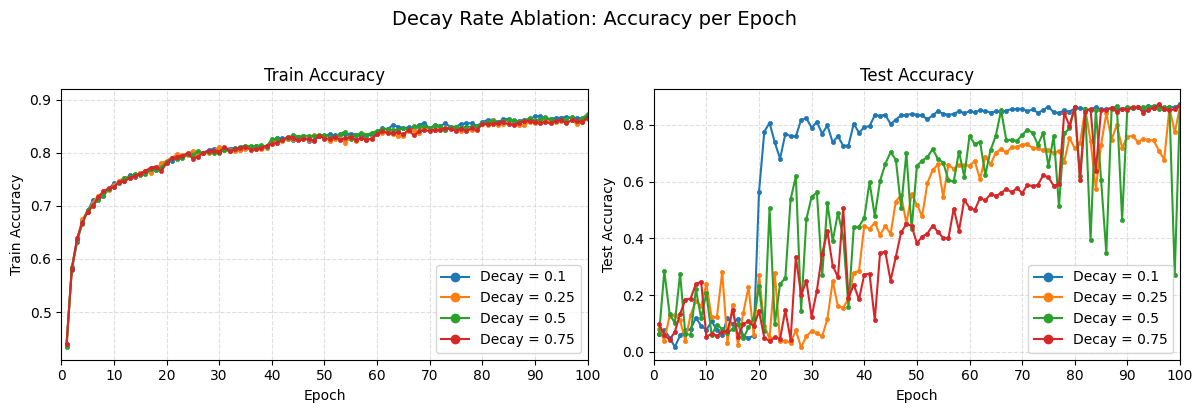

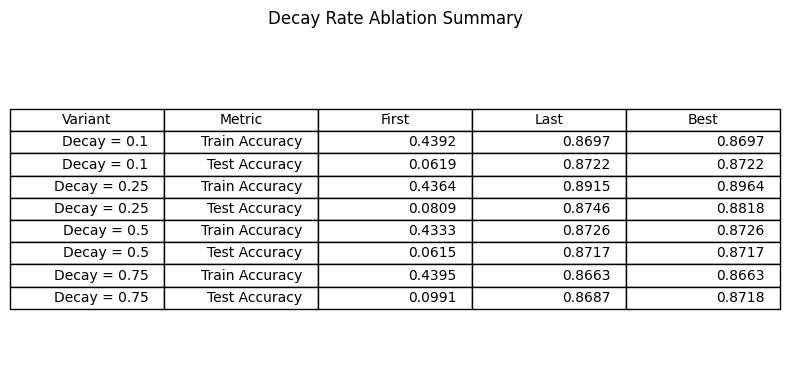

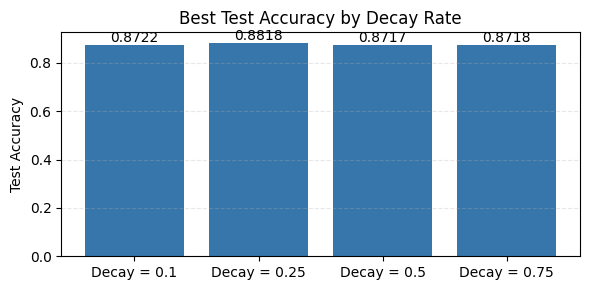

Detailed metrics:
  Decay = 0.1: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Decay = 0.25: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Decay = 0.5: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Decay = 0.75: first={_fmt(stats.get('first'))}, last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
Best-performing decay configuration: Decay = 0.25


In [11]:
import matplotlib.pyplot as plt
from pathlib import Path

metrics = {
    "Train Accuracy": ["train_acc"],
    "Test Accuracy": ["test_instance_acc", "test_acc"],
}

available_histories = {}
if 'results' in locals():
    for decay in sorted(results.keys()):
        payload = results[decay]
        history = payload.get('history', []) if isinstance(payload, dict) else []
        if history:
            available_histories[f"Decay = {decay}"] = history

if not available_histories:
    print('No training history available for visualization. Run the training cells above first.')
else:
    fig, axes = plot_training_curves(
        available_histories,
        metrics,
        title="Decay Rate Ablation: Accuracy per Epoch"
    )

    for ax in np.ravel(axes):
        # Reduce scatter marker size
        for line in ax.lines:
            line.set_marker("o")
            line.set_markersize(3)  # smaller dots
            line.set_markeredgewidth(0.5)
        # Limit range
        ax.set_xlim(0, 100)
        ax.grid(True, linestyle="--", alpha=0.4)
         
    figures_dir = Path("../log/figures") / "decay"
    figures_dir.mkdir(parents=True, exist_ok=True)
    curve_path = figures_dir / "accuracy_curves.png"
    fig.savefig(curve_path, dpi=150, bbox_inches="tight")
    plt.show()

    summary_stats = summarize_histories(available_histories, metrics)
    table_fig, table_ax = plot_metric_table(
        summary_stats,
        title="Decay Rate Ablation Summary",
        value_fmt="{:.4f}",
        include_first=True
    )
    table_path = figures_dir / "accuracy_summary.png"
    table_fig.savefig(table_path, dpi=150, bbox_inches="tight")
    plt.show()

    bar_fig, bar_ax = plot_metric_bars(
        summary_stats,
        metric_name="Test Accuracy",
        title="Best Test Accuracy by Decay Rate",
        ylabel="Test Accuracy"
    )
    bar_path = figures_dir / "best_accuracy.png"
    bar_fig.savefig(bar_path, dpi=150, bbox_inches="tight")
    plt.show()

    def _fmt(value):
        return '-' if value is None else f"{value:.4f}"

    print('Detailed metrics:')
    for label, metric_stats in summary_stats.items():
        stats = metric_stats.get("Test Accuracy", {})
        print(f"  {label}: first={{_fmt(stats.get('first'))}}, last={{_fmt(stats.get('last'))}}, best={{_fmt(stats.get('best'))}}")

    best_label = max(
        summary_stats.items(),
        key=lambda item: item[1].get("Test Accuracy", {}).get('best') or float('-inf')
    )[0]
    print(f"Best-performing decay configuration: {best_label}")


## Summary and Insights

In [12]:
print('\n' + '='*60)
print('ABLATION STUDY 2.4 SUMMARY: DECAY RATE')
print('='*60)

print('\n1. Final Accuracy Results:')
for decay in decay_values:
    acc = results[decay]['best_acc']
    print(f'   Decay Rate {decay:4.2f}: {acc:.4f}')

best_decay = max(decay_values, key=lambda d: results[d]['best_acc'])
best_acc = results[best_decay]['best_acc']
print(f'\n2. Best Decay Rate: {best_decay} with accuracy {best_acc:.4f}')

print('\n3. Key Insights:')
if best_decay <= 0.25:
    print('   - Lower decay rates perform best')
    print('   - Longer temporal integration (slower leakage) is beneficial')
    print('   - Neurons retain information longer')
elif best_decay >= 0.5:
    print('   - Higher decay rates perform best')
    print('   - Shorter temporal integration (faster leakage) is beneficial')
    print('   - Neurons are more responsive to new inputs')
else:
    print('   - Moderate decay rates perform best')
    print('   - Balance between memory and responsiveness')
    print('   - Default decay of 0.25 is well-chosen')

print('\n4. Temporal Integration Properties:')
print(f'   - Decay={min(decay_values)}: Longest memory (slowest leakage)')
print(f'   - Decay={max(decay_values)}: Shortest memory (fastest leakage)')
print(f'   - Optimal: Decay={best_decay}')

print('\n5. Recommendations:')
print(f'   - Use decay rate={best_decay} for optimal performance')
print('   - Decay rate affects temporal dynamics and memory')
print('   - Consider task-specific tuning based on temporal requirements')

print('\n' + '='*60)


ABLATION STUDY 2.4 SUMMARY: DECAY RATE

1. Final Accuracy Results:
   Decay Rate 0.10: 0.8722
   Decay Rate 0.25: 0.8818
   Decay Rate 0.50: 0.8717
   Decay Rate 0.75: 0.8718

2. Best Decay Rate: 0.25 with accuracy 0.8818

3. Key Insights:
   - Lower decay rates perform best
   - Longer temporal integration (slower leakage) is beneficial
   - Neurons retain information longer

4. Temporal Integration Properties:
   - Decay=0.1: Longest memory (slowest leakage)
   - Decay=0.75: Shortest memory (fastest leakage)
   - Optimal: Decay=0.25

5. Recommendations:
   - Use decay rate=0.25 for optimal performance
   - Decay rate affects temporal dynamics and memory
   - Consider task-specific tuning based on temporal requirements

